# Лабораторная № 4. "Изучение ZooKeeper"

### Задание:

1. С использованием Zookeeper сервиса решите проблему обедающих философов (каждый философ - отдельный процесс в системе)
2. С использованием Zookeeper сервиса реализуйте двуфазный коммит протокол для high-available регистра (каждый регистр - отдельный процесс в системе)

## Введение. Установка соединения и проверка работы

In [ ]:
установлен Zookeeper версии 3.4.14

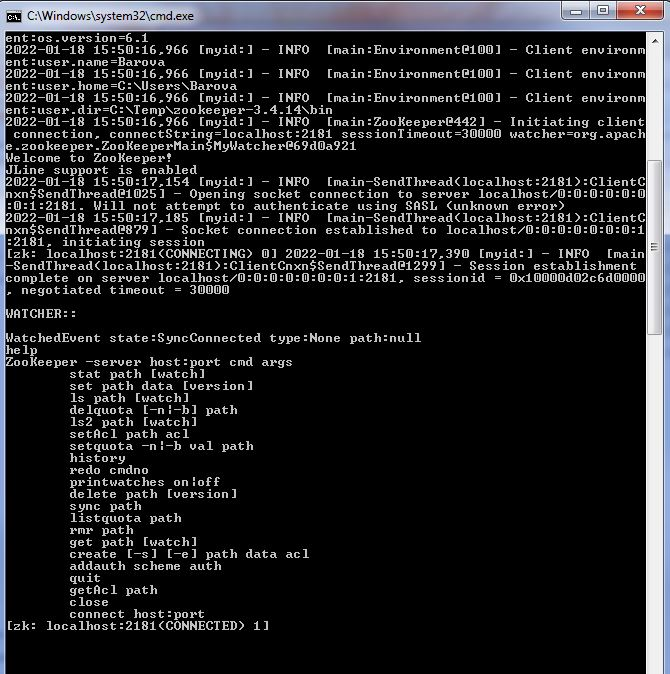

In [8]:
from PIL import Image, ImageDraw, ImageFont
img_color = Image.open('zoo.jpg')
display(img_color)

Библиотека более позних версий конфликтует с текущей версией Zookeeper. Поэтому выбрали версию 2.6.1

In [2]:
pip install kazoo==2.6.1

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



Чтобы начать использовать Kazoo, необходимо создать объект KazooClient и установить соединение:

In [3]:
from kazoo.client import KazooClient

In [7]:
zk = KazooClient()

# начать соединение
zk.start()

In [29]:
# настройка ведения журнала

import logging
logging.basicConfig()

### Zookeeper CRUD (create, read, update, delete).

Zookeeper включает в себя несколько функций для создания, чтения, обновления и удаления узлов Zookeeper 
(znodes или узлы). 

Kazoo добавляет несколько удобных методов и более Pythonic API.

##### Создание

create() - создает узел и может устанавливать данные на узле вместе с функцией наблюдения. 

Для этого требуется, чтобы путь к нему существовал первым, если дляmakepathне установлено значениеTrue.

In [15]:
# указать путь или создать
zk.ensure_path("/data")

'/my/favorite'

In [17]:
# создать узел с данными
zk.create("/data/node", b"a value")

'/data/node'

##### Чтение данных

Методы:

exists() проверяет, существует ли узел.

get() извлекает данные узла вместе с подробной информацией об узле в структуре ZnodeStat .

get_children() получает список дочерних элементов данного узла.



In [18]:
# Проверяем, существует ли узел
if zk.exists("/my/favorite"):
    print('узел найден')

узел найден


In [20]:
# Выводим информацию об узле
data, stat = zk.get("/my/favorite")
print("Версия: %s, data: %s" % (stat.version, data.decode("utf-8")))

Версия: 0, data: 


In [21]:
# Выводим список дочерних элементов данного узла
children = zk.get_children("/my/favorite")
print("There are %s children with names %s" % (len(children), children))

There are 1 children with names ['node']


##### Обновление данных

set() обновляет данные для данного узла. 

Можно указать версию для узла, которая должна совпасть перед обновлением данных

(или вместо обновления выдаст ошибку)

In [22]:
zk.set("/my/favorite", b"some data")

ZnodeStat(czxid=12, mzxid=15, ctime=1642510637050, mtime=1642511693477, version=1, cversion=1, aversion=0, ephemeralOwner=0, dataLength=9, numChildren=1, pzxid=13)

##### Удаление

delete() удаляет узел и может также рекурсивно удалить все дочерние элементы узла. 

При удалении узла может быть указана версия, которая должна соответствовать версии узла перед его удалением, 

(вместо удаления  выдаст ошибку) 

In [26]:
zk.delete("/my/favorite/node", recursive=True)

True

In [28]:
# Проверяем, существует ли узел
if zk.exists("/my/favorite/node"):
    print('узел найден')
else:
    print('узел НЕ найден')

узел НЕ найден


In [34]:
# прервать соединение
zk.stop()

### Задание 1.
###### С использованием Zookeeper сервиса решите проблему обедающих философов (каждый философ - отдельный процесс в системе)

Иллюстрация проблемы обедающих философов

Пять безмолвных философов сидят вокруг круглого стола, перед каждым философом стоит тарелка спагетти. 

Вилки лежат на столе между каждой парой ближайших философов.

Каждый философ может либо есть, либо размышлять. 

Приём пищи не ограничен количеством оставшихся спагетти — подразумевается бесконечный запас. 

Тем не менее, философ может есть только тогда, когда держит две вилки — взятую справа и слева 

(альтернативная формулировка проблемы подразумевает миски с рисом и палочки для еды вместо тарелок со спагетти и вилок).

Каждый философ может взять ближайшую вилку (если она доступна), или положить — если он уже держит её. 

Взятие каждой вилки и возвращение её на стол являются раздельными действиями, которые должны выполняться одно за другим.

Суть проблемы заключается в том, чтобы разработать модель поведения (параллельный алгоритм), 

при котором ни один из философов не будет голодать, то есть будет вечно чередовать приём пищи и размышления.

In [1]:
from time import time, sleep

In [2]:
from kazoo.client import KazooClient

In [3]:
# настройка ведения журнала

import logging
logging.basicConfig()

In [4]:
import random
from time import sleep
import threading

In [5]:
# состояние философов (ест / не ест)

class PhilosopherState():
    eating = 1
    thinking = 0

In [6]:
class Philosopher(threading.Thread):


    def __init__(self, name, resource):
        self._philosopher_name = name
        self._eating_time = 5
        self._state = PhilosopherState.thinking
        self._resource_pointer = [Fork()]
        threading.Thread.__init__(self) 

    @property
    def philosopher_name(self):
        return self._philosopher_name

    @philosopher_name.setter
    def philosopher_name(self, name):
        self._philosopher_name = name

    @property
    def state(self):
        return self._state

    @state.setter
    def state(self, state):
        self._state = state


    def eat(self, chopsticks):
        self.state(PhilosopherState.eating)
        print ("Philosopher {} is eating.".format(self.philosopher_name))
        sleep(self._eating_time)
        for f in Fork:
            f.state = Fork.free
            f.owner = None

    def think(self):
        self.state = PhilosopherState.thinking
        print ("Philosopher {} is thinking.".format(self.philosopher_name))
        sleep(random.randint(1,10))

    def run(self):
        zk = KazooClient()
        zk.start()
        start = time()
        
        print("Philosopher {} has joined the table.".format(self.philosopher_name))
        
        while time() - start < N:
            acquired_chopsticks = []
            for f in self._resource_pointer:
                if Fork.state == ForkState.free:
                    Fork.state = ForkState.busy
                    Fork.owner = self.name
                    acquired_Fork.append(Fork)
                    if len(acquired_Fork) == 2:
                        self.eat()
                else:
                        self.think()
        zk.stop()
        zk.close()



In [7]:
# состояние вилки (свободна / занята)

class ForkState():
    free = 1
    busy = 0

In [8]:
class Fork():

    def __init__(self):
        self._state = ForkState.free
        self._owner = None

    @property
    def owner(self):
        return self.owner

    @owner.setter
    def owner(self, owner):
        self._owner = owner

    @property
    def state(self):
        return self._state

    @state.setter
    def state(self, state):
        self._state = state


In [9]:
master_zk = KazooClient()
master_zk.start()

if master_zk.exists('/task1'):
    master_zk.delete('/task1', recursive=True)

master_zk.create('/task1')
master_zk.create('/task1/table')
master_zk.create('/task1/forks')
master_zk.create('/task1/forks/1')
master_zk.create('/task1/forks/2')
master_zk.create('/task1/forks/3')
master_zk.create('/task1/forks/4')
master_zk.create('/task1/forks/5')

fork_array = 'forks'

N = 20

for i in range(5):
    p = Philosopher(i, fork_array)
    p.start()


Philosopher 0 has joined the table.
Philosopher 0 is thinking.
Philosopher 1 has joined the table.
Philosopher 1 is thinking.
Philosopher 2 has joined the table.
Philosopher 2 is thinking.
Philosopher 4 has joined the table.
Philosopher 3 has joined the table.
Philosopher 3 is thinking.
Philosopher 4 is thinking.
Philosopher 1 is thinking.
Philosopher 3 is thinking.Philosopher 4 is thinking.

Philosopher 2 is thinking.
Philosopher 0 is thinking.
Philosopher 4 is thinking.
Philosopher 1 is thinking.
Philosopher 3 is thinking.
Philosopher 2 is thinking.
Philosopher 4 is thinking.
Philosopher 0 is thinking.
Philosopher 1 is thinking.
Philosopher 0 is thinking.
Philosopher 1 is thinking.
Philosopher 3 is thinking.
